##***DeepFake Detection Using Deep Learning***




This notebook was used to train the Pure EfficientNet Model with default hyperparameters proposed as stated in the project report 

## **Setup and Library Imports**

In [1]:
import os
import glob
import random
import torch
import cv2
from torch import nn
import seaborn as sn
import pandas as pd
import numpy as np

from torchvision import transforms
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
import matplotlib.pyplot as plt 

import torch.nn.functional as F
from torchvision import models
from sklearn.metrics import confusion_matrix
from tqdm.notebook import tqdm

In [2]:
seed=40302
random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

## **Helper Functions**

In [7]:
os.chdir('../')
os.getcwd()

'h:\\project'

In [9]:
from src.utils import *

## **Data Reading, Splitting and Loading**

In [10]:
dfdc_folders = glob.glob(os.getcwd() + '/data/dfdc/dfdc*')
dfdc_folders = sorted(dfdc_folders, key=lambda x: x)
all_dataframes = []
for train_dir in dfdc_folders:
    df = pd.read_csv(os.path.join(train_dir, 'metadata.csv'))
    df['path'] = df['filename'].apply(lambda x: os.path.join(train_dir, x.split('.')[0]))
    all_dataframes.append(df)

dfdc_df = pd.concat(all_dataframes, ignore_index=True, sort=False)


In [11]:
dfdc_df.label.value_counts()

FAKE    8486
REAL    1012
Name: label, dtype: int64

In [12]:
dfdc_df['origin'] = 'dfdc'
dfdc_df.drop(['split', 'original'],axis=1, inplace=True)
dfdc_df.head()

,filename,label,path,origin
0,crnkpgykgj.mp4,FAKE,h:\project/data/dfdc\dfdc_part3_0\crnkpgykgj,dfdc
1,buhvwnaupu.mp4,FAKE,h:\project/data/dfdc\dfdc_part3_0\buhvwnaupu,dfdc
2,rvrlzxepiu.mp4,FAKE,h:\project/data/dfdc\dfdc_part3_0\rvrlzxepiu,dfdc
3,atvucyyltw.mp4,FAKE,h:\project/data/dfdc\dfdc_part3_0\atvucyyltw,dfdc
4,emxknhlufj.mp4,FAKE,h:\project/data/dfdc\dfdc_part3_0\emxknhlufj,dfdc


In [13]:
celeb_df =  pd.read_csv('./data/celeb_metadata.csv')

In [14]:
celeb_df['path'] = celeb_df['Unnamed: 0'].apply(lambda x: os.path.join('./data/CelebDF-v2/faces', x.split('.')[0]))
celeb_df.drop(['img_dir', 'fullpath'], axis=1, inplace=True)
celeb_df.rename(columns={'Unnamed: 0':'filename'}, inplace=True)
celeb_df = celeb_df[['filename', 'label', 'path', 'origin']]
celeb_df.head()

,filename,label,path,origin
0,id0_0000.mp4,REAL,./data/CelebDF-v2/faces\id0_0000,CelebDF-v2
1,id0_0001.mp4,REAL,./data/CelebDF-v2/faces\id0_0001,CelebDF-v2
2,id0_0002.mp4,REAL,./data/CelebDF-v2/faces\id0_0002,CelebDF-v2
3,id0_0003.mp4,REAL,./data/CelebDF-v2/faces\id0_0003,CelebDF-v2
4,id0_0004.mp4,REAL,./data/CelebDF-v2/faces\id0_0004,CelebDF-v2


In [15]:
celeb_df.shape

(6529, 4)

We get the test samples listed by the Celeb_DF2 for testing

In [19]:
df2 = pd.read_csv('./data/CelebDF-v2/List_of_testing_videos.txt', delimiter=' ', header=None)
df2[1] = df2[1].apply(lambda s: s.split('/')[-1])
df2.shape

(518, 2)

In [20]:
test_celeb = celeb_df.loc[celeb_df.filename.isin(df2[1].tolist())].reset_index(drop=True)
celeb_df.drop(test_celeb.index, inplace=True)
celeb_df.reset_index(drop=True, inplace=True)
test_celeb.label.value_counts()

FAKE    340
REAL    178
Name: label, dtype: int64

In [21]:
celeb_df.shape

(6011, 4)

In [22]:
ytf_df = pd.read_csv('./data/youtube_faces_dataset/youtube_faces_50f.csv')
ytf_df['label'] = 'REAL'
ytf_df['origin'] = 'ytf'
ytf_df['path'] = ytf_df['videoID'].apply(lambda x: os.path.join('./data/youtube_faces_dataset/faces', x))
ytf_df.head()

ytf_df.drop(['Unnamed: 0', 'personName', 'imageHeight', 'imageWidth', 'videoDuration', 'averageFaceSize', 'numVideosForPerson'], axis=1, inplace=True)
ytf_df.rename(columns={'videoID':'filename'}, inplace=True)
ytf_df = ytf_df[['filename', 'label', 'path', 'origin']]
ytf_df.head()

,filename,label,path,origin
0,Alison_Lohman_0,REAL,./data/youtube_faces_dataset/faces\Alison_Lohm...,ytf
1,Alison_Lohman_1,REAL,./data/youtube_faces_dataset/faces\Alison_Lohm...,ytf
2,Alison_Lohman_2,REAL,./data/youtube_faces_dataset/faces\Alison_Lohm...,ytf
3,Alison_Lohman_3,REAL,./data/youtube_faces_dataset/faces\Alison_Lohm...,ytf
4,Alison_Lohman_4,REAL,./data/youtube_faces_dataset/faces\Alison_Lohm...,ytf


In [23]:
x = [False for n in range(len(ytf_df.path))]
for i,path in enumerate(ytf_df.path.tolist()):
    already_present_count =  len(glob.glob(path+'/*'))
    if already_present_count >= 50:
        x[i] = True
ytf_df = ytf_df[x].reset_index(drop=True)
ytf_df.shape

(1618, 4)

In [24]:
df = pd.concat([dfdc_df, celeb_df, ytf_df ], ignore_index=True, sort=False)
df.label.value_counts()

FAKE    14125
REAL     3002
Name: label, dtype: int64

In [25]:
df.origin.value_counts()

dfdc          9498
CelebDF-v2    6011
ytf           1618
Name: origin, dtype: int64

Dealing with class imbalance

We will use first 50 frames for each video, but for DFDC we have 300 frames available and for CelebDF-v2 150 frames so we will create additional rows for subsequent blocks of 50 frames in the video

Additionaly we will use inverted frame for all real samples to duplicate all data

In [26]:
df['frames'] = 1
df['inv_frame'] = 0

In [27]:
import numpy as np
from sklearn.model_selection import StratifiedShuffleSplit

def get_split(data, size=0.2):
  sss = StratifiedShuffleSplit(n_splits=1, test_size=size, random_state=seed)

  for a,b in sss.split(np.arange(data.shape[0]), data.label):
    train_idx, test_idx = a,b 

  return train_idx, test_idx

In [28]:
_, _test = get_split(df, 0.2)
test_df = df.loc[_test, :]
test_df.shape

(3426, 6)

In [29]:
test_df.label.value_counts()

FAKE    2825
REAL     601
Name: label, dtype: int64

In [30]:
df.drop(_test, inplace=True)
df.reset_index(drop=True, inplace=True)
df.shape

(13701, 6)

In [31]:
train_idx, val_idx = get_split(df, 0.2)
train_df = df.loc[train_idx,:].reset_index(drop=True)
valid_df = df.loc[val_idx,:].reset_index(drop=True)

In [32]:
train_df.label.value_counts()

FAKE    9039
REAL    1921
Name: label, dtype: int64

In [33]:
valid_df.label.value_counts()

FAKE    2261
REAL     480
Name: label, dtype: int64

In [34]:
valid_df.origin.value_counts()

dfdc          1520
CelebDF-v2     970
ytf            251
Name: origin, dtype: int64

In [35]:
real_dfdc = train_df[(train_df['label'] == 'REAL') & (train_df['origin'] == 'dfdc')].reset_index(drop=True)

real_celeb = train_df[(train_df['label'] == 'REAL') & (train_df['origin'] == 'CelebDF-v2')].reset_index(drop=True)

In [36]:
for i in range(2,4):
    if i <= 3:
        real_celeb.frames = i
        real_celeb_i = real_celeb.copy()
        real_celeb_i.inv_frame = 1
        train_df = pd.concat([train_df, real_celeb_i], ignore_index=True, sort=False)
    real_dfdc.frames = i
    real_dfdc_i = real_dfdc.copy()
    real_dfdc_i.inv_frame = 1
    train_df = pd.concat([train_df, real_dfdc_i], ignore_index=True, sort=False)

In [37]:
train_df.label.value_counts()

FAKE    9039
REAL    3683
Name: label, dtype: int64

In [38]:
train_df.origin.value_counts()

dfdc          7352
CelebDF-v2    4330
ytf           1040
Name: origin, dtype: int64

Next we undersample the fake videos to allow the classes to be balanced

In [39]:
train_df.drop(train_df[(train_df['label'] == 'FAKE') & (train_df['origin'] == 'dfdc')].sample(4000).index, inplace=True)


train_df.drop(train_df[(train_df['label'] == 'FAKE') & (train_df['origin'] == 'CelebDF-v2')].sample(1300).index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [40]:
valid_df.drop(valid_df[(valid_df['label'] == 'FAKE') & (valid_df['origin'] == 'dfdc')].sample(1000).index, inplace=True)


valid_df.drop(valid_df[(valid_df['label'] == 'FAKE') & (valid_df['origin'] == 'CelebDF-v2')].sample(400).index, inplace=True)
df.reset_index(drop=True, inplace=True)

In [41]:
train_df.label.value_counts()

FAKE    3739
REAL    3683
Name: label, dtype: int64

In [42]:
valid_df.label.value_counts()

FAKE    861
REAL    480
Name: label, dtype: int64

In [43]:
df.sample(10)

,filename,label,path,origin,frames,inv_frame
10378,id20_id17_0002.mp4,FAKE,./data/CelebDF-v2/faces\id20_id17_0002,CelebDF-v2,1,0
13480,Madeleine_Albright_5,REAL,./data/youtube_faces_dataset/faces\Madeleine_A...,ytf,1,0
1797,kqfhsniyug.mp4,FAKE,h:\project/data/dfdc\dfdc_part4_1\kqfhsniyug,dfdc,1,0
204,ojqaffhyse.mp4,FAKE,h:\project/data/dfdc\dfdc_part3_0\ojqaffhyse,dfdc,1,0
3971,hrbkraauwx.mp4,FAKE,h:\project/data/dfdc\dfdc_part_0_0\hrbkraauwx,dfdc,1,0
1156,qsrzkstona.mp4,FAKE,h:\project/data/dfdc\dfdc_part3_1\qsrzkstona,dfdc,1,0
12237,id30_id2_0006.mp4,FAKE,./data/CelebDF-v2/faces\id30_id2_0006,CelebDF-v2,1,0
695,kulhlphfrb.mp4,FAKE,h:\project/data/dfdc\dfdc_part3_1\kulhlphfrb,dfdc,1,0
9533,id1_id30_0007.mp4,FAKE,./data/CelebDF-v2/faces\id1_id30_0007,CelebDF-v2,1,0
12447,Fred_Eckhard_3,REAL,./data/youtube_faces_dataset/faces\Fred_Eckhard_3,ytf,1,0


In [44]:
from src.dataset.transformations import transforms_inv, train_transforms, test_transforms

In [48]:
from src.dataset import VideoDataset

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


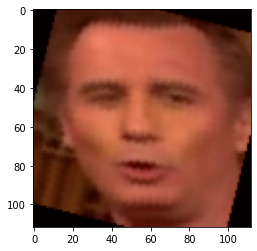

In [50]:
#preprocess the data
train_data = VideoDataset(train_df, frames_to_use = 50, im_size= 112, transform = train_transforms(112))
val_data = VideoDataset(valid_df, frames_to_use = 50, im_size=112,  transform = test_transforms(112))

#load the data into dataloaders
train_loader = DataLoader(train_data, batch_size = 4, shuffle = True, num_workers = 0)
valid_loader = DataLoader(val_data, batch_size = 4, shuffle = True, num_workers = 0)

#plot the data
image,label = train_data[1500]
im_plot(image[49,:,:,:])

## **Model 1 : Efficientnet

In [44]:
#Model with Pretrained Efficient Net with GRU 
class Efficientnet(nn.Module):
    def __init__(self, num_classes):
        super(Efficientnet, self).__init__()
        model = models.efficientnet_b0(pretrained = True) #Pretrained Efficient Net b0 Model

        n_inputs = model.classifier[1].in_features
        self.model = nn.Sequential(*list(model.children())[:-2])
        self.linear1 = nn.Linear(n_inputs ,256)
        self.linear2 = nn.Linear(256,128)
        self.dp = nn.Dropout(0.3)
        self.linear3 = nn.Linear(128,num_classes)
        self.avgpool = nn.AdaptiveAvgPool2d(1)
        
    def forward(self, x):

        batch_size,frames_to_use, c, h, w = x.shape 
        x = x.view(batch_size * frames_to_use, c, h, w)
        fmap = self.model(x)

        x = self.avgpool(fmap)
        x = x.view(x.shape[0],-1)
        x = F.leaky_relu(self.linear1(x))
        x = F.leaky_relu(self.dp(self.linear2(x)))
        x = self.linear3(x)

        output = F.softmax(x, dim=1)

        return output

In [45]:
#instantiate the model
model1 = Efficientnet(2).cuda()
#model1 = CNNModel().cuda()

C:\Users\leovc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\leovc\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [46]:
print(model1)

Efficientnet(
  (model): Sequential(
    (0): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): SiLU(inplace=True)
      )
      (1): Sequential(
        (0): MBConv(
          (block): Sequential(
            (0): Conv2dNormActivation(
              (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
              (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
              (2): SiLU(inplace=True)
            )
            (1): SqueezeExcitation(
              (avgpool): AdaptiveAvgPool2d(output_size=1)
              (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (activation): SiLU(inplace=True)
              (scale_activation)

In [47]:
#train function for CNN Model
def train_epoch(epoch, data_loader, model, criterion, optimizer):
    model.train()
    losses = AverageMeter()
    accuracies = AverageMeter()
    t = []
    
    pbar = tqdm(enumerate(data_loader), total=len(data_loader))
    
    for i, (inputs, targets) in pbar:
       
        
        targets = targets.type(torch.cuda.LongTensor)
        inputs = inputs.cuda()

        bs,frames_to_use, *_= inputs.shape
        outputs = model(inputs)   #call the model with inputs
        results = torch.zeros((bs,2)).cuda()
        
        #takes each sequence of frames that composes one video and calculate the mean output as the result
        for k, j in enumerate(range(0,bs*frames_to_use,frames_to_use)):
            results[k] = torch.mean(outputs[j:j+frames_to_use],dim=0)   
        
        #calculate loss and accuracy

        loss  = criterion(results,targets)  
        acc = calculate_accuracy(results, targets)
        losses.update(loss.item(), inputs.size(0))
        accuracies.update(acc, inputs.size(0))
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #add comment to progress bar 
        description = f'epoch {epoch} loss: {losses.avg:.4f} {accuracies.avg:.2f}'   
        pbar.set_description(description)
    
    return losses.avg,accuracies.avg

#validate function
def run_inference(model, data_loader ,criterion):
    print('Testing')
    model.eval()
    losses = AverageMeter()
    accuracies = AverageMeter()
    pred = []
    true = []
    count = 0
    with torch.no_grad():
        
        pbar = tqdm(enumerate(data_loader), total=len(data_loader))
        
        for i, (inputs, targets) in pbar:

            targets = targets.cuda().type(torch.cuda.LongTensor)
            inputs = inputs.cuda()
           
            bs,frames_to_use, *_ = inputs.shape
            outputs = model(inputs)
            results = torch.zeros((bs,2)).cuda()

            for k, j in enumerate(range(0,bs*frames_to_use,frames_to_use)):
                results[k] = torch.mean(outputs[j:j+frames_to_use],dim=0)
            
            loss = torch.mean(criterion(results, targets))
            acc = calculate_accuracy(results,targets)
            _,p = torch.max(results,1) 
            true += (targets).detach().cpu().numpy().reshape(len(targets)).tolist()
            pred += p.detach().cpu().numpy().reshape(len(p)).tolist()
            losses.update(loss.item(), inputs.size(0))
            accuracies.update(acc, inputs.size(0))

        print('\nAccuracy {}'.format(accuracies.avg))
        
    return true,pred,losses.avg,accuracies.avg

In [48]:
torch.cuda.is_available()

True

In [49]:
#learning rate
lr = 0.001

#number of epochs 
num_epochs = 12

optimizer = torch.optim.Adam(model1.parameters(), lr= lr, weight_decay = 1e-5)

criterion = nn.CrossEntropyLoss().cuda()
train_loss_avg =[]
train_accuracy = []
val_loss_avg = []
val_accuracy = []
best_accuracy = 0
for epoch in range(1,num_epochs+1):
    l, acc = train_epoch(epoch,train_loader,model1,criterion,optimizer)
    train_loss_avg.append(l)
    train_accuracy.append(acc)
    #validation step
    true,pred,tl,t_acc = run_inference(model1,valid_loader,criterion)
    val_loss_avg.append(tl)
    val_accuracy.append(t_acc)
    if t_acc > best_accuracy:
        best_accuracy = t_acc
        torch.save(model1.state_dict(),'./effnet_{}.pt'.format(epoch))
    

  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 81.50633855331841


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 84.3400447427293


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 84.862043251305


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 79.56748695003729


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 81.4317673378076


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 89.85831469052945


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 86.12975391498881


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 87.1737509321402


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 87.8448918717375


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 86.20432513049963


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 87.02460850111856


  0%|          | 0/1856 [00:00<?, ?it/s]

Testing


  0%|          | 0/336 [00:00<?, ?it/s]


Accuracy 86.87546607009695


In [50]:
test_data = VideoDataset(test_df, frames_to_use = 50, im_size=112, transform = test_transforms(112))
tst_loader = DataLoader(test_data, batch_size = 2, shuffle = True, num_workers = 0)
criterion = nn.CrossEntropyLoss().cuda()
true,pred,tl,t_acc = run_inference(model1,tst_loader,criterion)

Testing


  0%|          | 0/1713 [00:00<?, ?it/s]


Accuracy 83.04144775248103


In [51]:
test_celeb.label.value_counts()

FAKE    340
REAL    178
Name: label, dtype: int64

In [53]:
test_celeb['frames'] = 1
test_celeb['inv_frame'] = 0

test_data = VideoDataset(test_celeb, frames_to_use = 50, im_size=112, transform = test_transforms(112))
tst_loader = DataLoader(test_data, batch_size = 2, shuffle = True, num_workers = 6)
criterion = nn.CrossEntropyLoss().cuda()
run_inference(model1,tst_loader,criterion)



Testing


  0%|          | 0/259 [00:00<?, ?it/s]

RuntimeError: DataLoader worker (pid(s) 464, 16100, 17304, 8320, 23444, 32580) exited unexpectedly

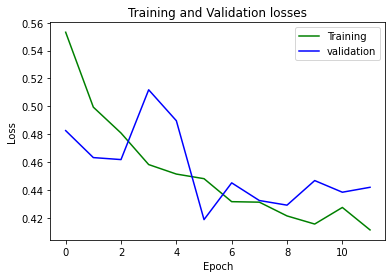

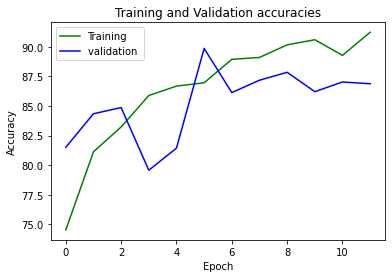

In [54]:
#plot of loss and accuracy for CNN
plot_loss(train_loss_avg,val_loss_avg,len(train_loss_avg))
plot_accuracy(train_accuracy,val_accuracy,len(train_accuracy))

[[2321  504]
 [  77  524]]


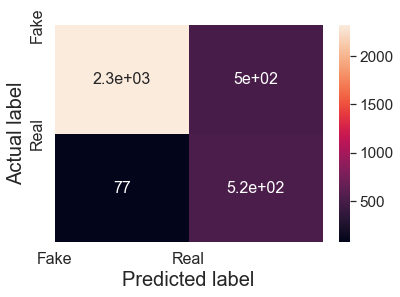

True positives =  2321
False positives =  504
False negatives =  77
True negatives =  524


Accuracy:  83.04144775248102
Precision:  0.8215929203539823
Recall:  0.9678899082568807


In [55]:
#confusion matrix for CNN 
print(confusion_matrix(true,pred)) 
print_confusion_matrix(true,pred) 